# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_TOD/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov
from simulation import * 

## A. Simulation

In [2]:
nside = 64

### 1. Define the two scans (rising and setting)
Tsky parameters and operators

In [3]:
# Get the timestream of beam centers (theta_c, phi_c) for each scan
t_list, theta_c_setting, phi_c_setting = sim_MeerKAT_scan(elevation=41.5, az_s=-60.3, az_e=-42.3, start_time_utc="2019-04-23 20:41:56.397")
bool_map_setting, integrated_beam_setting = stacked_beam_map(theta_c_setting, 
                                       phi_c_setting, 
                                       FWHM=1.1, 
                                       NSIDE=nside, 
                                       threshold = 0.0111) # This threshold cut off the beam directions outside the 3sigma region.

In [4]:
full_bool_map = bool_map_setting
pixel_indices = np.where(full_bool_map)[0]
integrated_beam = integrated_beam_setting 

Tsky_operator_setting = generate_Tsky_proj(full_bool_map, theta_c_setting, phi_c_setting, FWHM=1.1)

In [5]:
def sky_vector(pixel_indices, freq, Nside=64, sky_model=None):
    if sky_model is None:
        from pygdsm import GlobalSkyModel
        gsm = GlobalSkyModel()
        skymap = gsm.generate(freq)
    else:
        skymap = sky_model(freq)
    skymap = hp.ud_grade(skymap, nside_out=Nside)
    ptsrc = np.load("gleam_nside512_K_allsky_408MHz.npy")
    ptsrc_map = hp.ud_grade(ptsrc, nside_out=Nside)
    skymap = skymap + ptsrc_map
    return skymap[pixel_indices]

sky_params = sky_vector(pixel_indices, 408, Nside=nside, sky_model=None)
print("Number of pixels: ", len(pixel_indices))

Number of pixels:  375


### 2. Define Tdiode and Trec

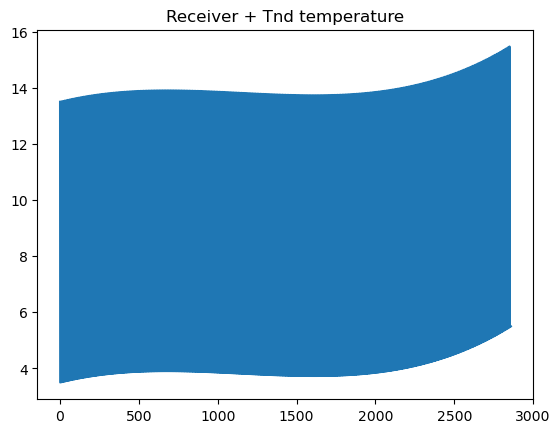

In [6]:
# generate a vector of length ntime, every 10 elements there is a 1, the rest is 0
def generate_vector(ntime):
    vector = np.zeros(ntime)
    for i in range(0, ntime, 10):
        vector[i] = 1
    return vector

ntime = len(t_list)
ndiode_proj = generate_vector(ntime)

nd_rec_operator = np.zeros((ntime, 5))
nd_rec_operator[:, 0] = ndiode_proj    # The noise diode part
nd_rec_operator[:, 1:] = Leg_poly_proj(4, t_list) # The Legendre polynomial (receiver temperature and all) part

T_ndiode = 10.0
rec_params=np.array([4, 0.5, 0.5, 0.5]) # The receiver temperature and all
nd_rec_params = np.zeros(5)
nd_rec_params[0] = T_ndiode
nd_rec_params[1:] = rec_params

plt.title("Receiver + Tnd temperature")
plt.plot(nd_rec_operator @ nd_rec_params)

### 3. Define Gain and Noise

In [7]:
gain_proj = Leg_poly_proj(4, t_list)

#gain_params_setting = np.random.uniform(low=0.0, high=1.0, size=4) + np.array([6., 0., 0., 0.])
gain_params_setting = np.array([6.31194264, 0.42038942, 0.264222, 0.05578821])

gains_setting = gain_proj @ gain_params_setting
print(gain_params_setting)
# save the gain parameters
# np.savez('outputs/GSF5/gain_params.npy', gain_params_setting)

[6.31194264 0.42038942 0.264222   0.05578821]


In [8]:
dtime = 2
fc = (1/ntime/dtime)*2*np.pi
logfc = np.log10(fc)
alpha = 2.0
logf0_list=[-4.874571109426952, -3.874259892646189, -2.901434432609383] 
# Corresponding to knee frequencies: 0.001. 0.01, 0.1
sigma_2 = 1/(4e5)

f0 = 10**logf0_list[0]

noise_setting = sim_noise(f0, fc, alpha, t_list, white_n_variance=sigma_2)

In [9]:
Tsys_setting = Tsky_operator_setting @ sky_params + nd_rec_operator @ nd_rec_params 
TOD_setting = Tsys_setting * (1+noise_setting) * gains_setting

## B. Sampling

In [10]:
# Convert theta/phi coordinates to HEALPix pixels
pixels_c_setting = [hp.ang2pix(nside=nside, theta=theta, phi=phi)
          for theta, phi in zip(theta_c_setting, phi_c_setting)]
bool_map_c_setting = np.zeros(hp.nside2npix(nside))
bool_map_c_setting[pixels_c_setting] = 1

In [11]:
top_20_beam_indices = np.argpartition(integrated_beam_setting[pixel_indices], -20)[-20:]
top_20_beam_indices.sort()

In [12]:
# For a 1D array 'integrated_beam_setting'
n_cal_pixs= 5
top_200_beam_indices = np.argpartition(integrated_beam_setting[pixel_indices], -200)[-200:]
# top_n_sky_indices = np.argpartition(sky_params[top_20_beam_indices], -n_cal_pixs)[-n_cal_pixs:]
# calibration_indices = top_20_beam_indices[top_n_sky_indices]
calibration_indices = [top_200_beam_indices[int(i* 200 / n_cal_pixs)] for i in range(n_cal_pixs)]

In [13]:
np.degrees(hp.pix2ang(nside, pixel_indices[calibration_indices]))

array([[ 90.59684183,  90.        ,  87.61198454,  83.42040706,
         84.62062101],
       [146.25      , 155.390625  , 152.578125  , 167.34375   ,
        167.34375   ]])

In [14]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params])
init_noise_params = [-4.8, 2.2]

gain_prior_cov_inv = np.zeros(4)
gain_prior_cov_inv[0] = 2.51 # DC mode: Prior STD ~10%
gain_prior_mean = gain_params_setting

prior_std_frac = 0.1
Tsky_prior_cov_inv = 1. / (prior_std_frac * sky_params)**2
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = np.ones_like(nd_rec_params)*0.0
aux[0] = 1
Trec_prior_cov_inv = [aux] 


def log_prior_noise(params):
    _, alpha_est = params
    return -1e10 * (alpha_est - alpha)**4 


In [15]:
from full_Gibbs_sampler import full_Gibbs_sampler_multi_TODS_v2

Tsys_samples, all_gain_samples, all_noise_samples = \
    full_Gibbs_sampler_multi_TODS_v2([TOD_setting],
                                    [t_list],
                                    [gain_proj],
                                    [Tsky_operator_setting],
                                    [nd_rec_operator],
                                    init_Tsys_params,
                                    init_noise_params, 
                                    [logfc],
                                    num_Jeffrey=False,
                                    wnoise_var=2.5e-6,
                                    Tsky_prior_cov_inv=Tsky_prior_cov_inv,
                                    Tsky_prior_mean=sky_params,
                                    local_Trec_prior_cov_inv_list=Trec_prior_cov_inv,
                                    local_Trec_prior_mean_list=[nd_rec_params],
                                    local_gain_prior_cov_inv_list=[gain_prior_cov_inv],
                                    local_gain_prior_mean_list=[gain_prior_mean],
                                    local_noise_prior_func_list=[log_prior_noise],
                                    n_samples=1000,
                                    tol=1e-12)

Rank: 0, local id: 0, gain_sample 0: [6.31198067 0.42005829 0.26719353 0.06078742]
Rank: 0, local id: 0, noise_sample 0: [-4.47149403  2.00392059]
Reached max iterations with fractional norm error 5.8909165918586095e-05.
Rank: 0, local id: 0, gain_sample 1: [6.31187949 0.42340827 0.27166134 0.0550938 ]
Rank: 0, local id: 0, noise_sample 1: [-4.36642476  1.9980195 ]
Reached max iterations with fractional norm error 0.000854540946072043.
Rank: 0, local id: 0, gain_sample 2: [6.3123295  0.424418   0.26915729 0.045953  ]
Rank: 0, local id: 0, noise_sample 2: [-4.7072771   2.00028008]
Reached max iterations with fractional norm error 0.00028744400938249417.
Rank: 0, local id: 0, gain_sample 3: [6.31218234 0.42680195 0.26622195 0.04525876]
Rank: 0, local id: 0, noise_sample 3: [-4.70070377  1.99923587]
Reached max iterations with fractional norm error 0.00024264327877215777.
Rank: 0, local id: 0, gain_sample 4: [6.31229458 0.42900047 0.26573471 0.04308147]
Rank: 0, local id: 0, noise_sample 

#### Visualize the Tsky samples

In [19]:
# Save the TOD simulation
np.save('outputs/GSF5/TOD_setting.npy', TOD_setting)

In [ ]:
# First, save the samples as npy files..

# np.save("outputs/GSF5/Tsys_samples.npy", Tsys_samples)
# np.save("outputs/GSF5/gain_samples.npy", np.concatenate(all_gain_samples, axis=0))
# np.save("outputs/GSF5/noise_samples.npy", np.concatenate(all_noise_samples, axis=0))

In [20]:
# Read the saved samples

Tsys_samples = np.load('outputs/GSF5/Tsys_samples.npy')
gain_samples = np.load('outputs/GSF5/gain_samples.npy')
noise_samples = np.load('outputs/GSF5/noise_samples.npy')


In [21]:
num_pixels = len(pixel_indices)
Tsky_samples = Tsys_samples[:, :num_pixels]
other_samples = np.hstack((gain_samples[0], Tsys_samples[:, num_pixels:], noise_samples[0]))
Tmean = np.mean(Tsky_samples, axis=0)
Tstd = np.std(Tsky_samples, axis=0)
Tresidual = Tmean - sky_params


NPIX = hp.nside2npix(nside)

true_map = np.zeros(NPIX, dtype=float)
sample_mean_map = np.zeros(NPIX, dtype=float)
sample_std_map = np.zeros(NPIX, dtype=float)

true_map[pixel_indices] = sky_params
sample_mean_map[pixel_indices] = Tmean
sample_std_map[pixel_indices] = Tstd

The mean residual is:  -0.4198561880367497
16th percentile:  -0.5039546874233599
84th percentile:  0.8455219834131998


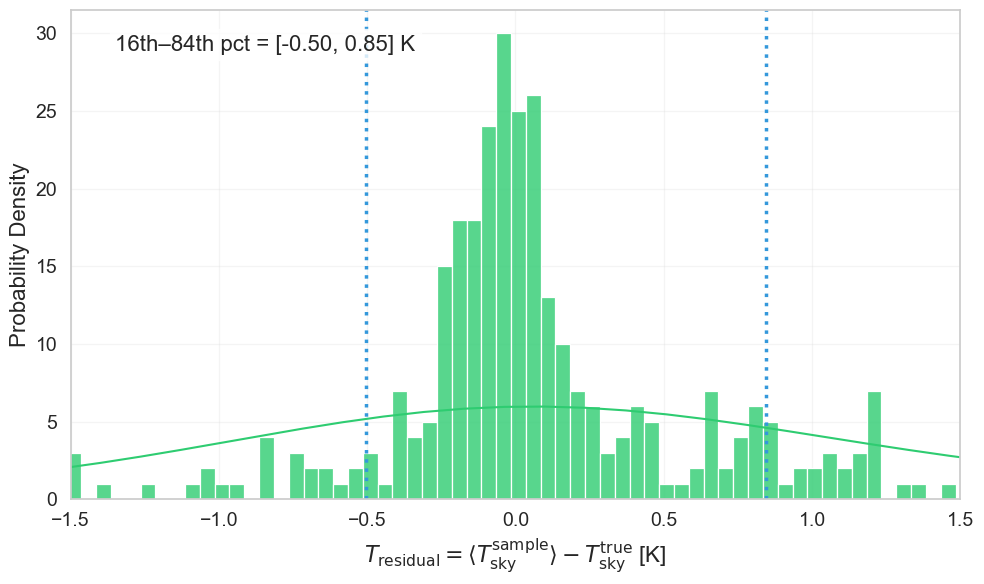

Corner plot saved to ./GSF5_corner_plot.pdf


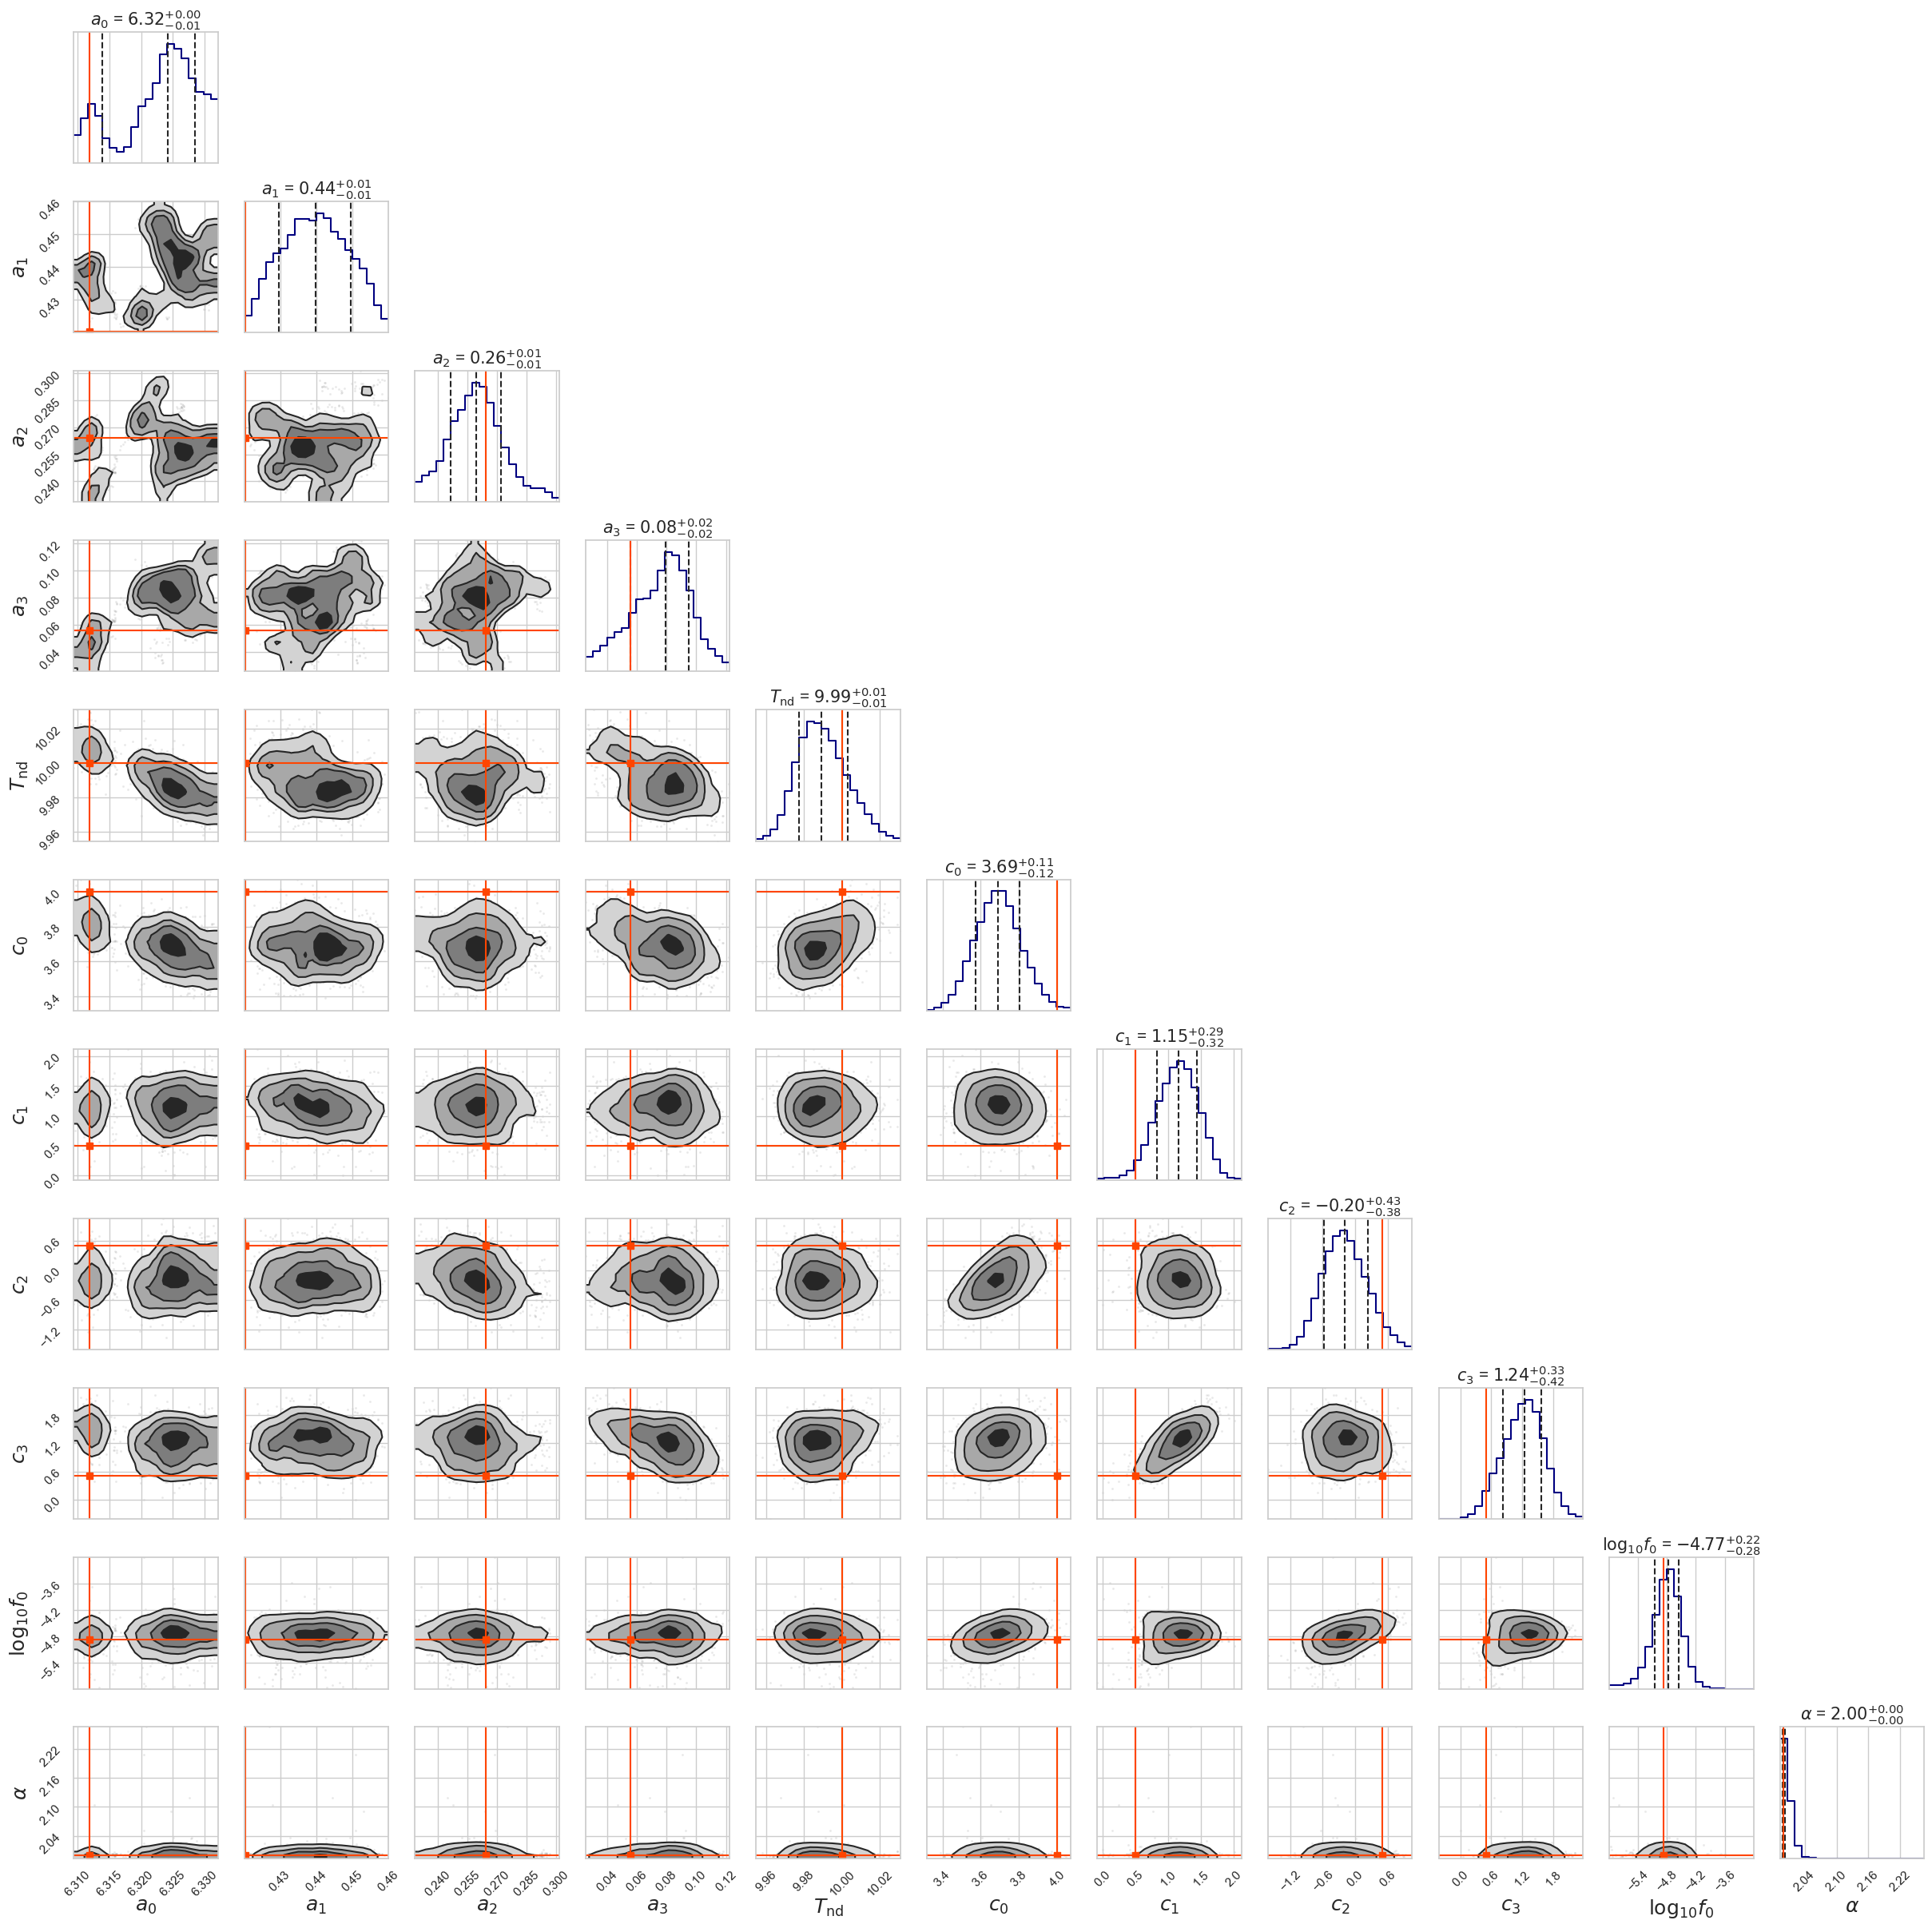

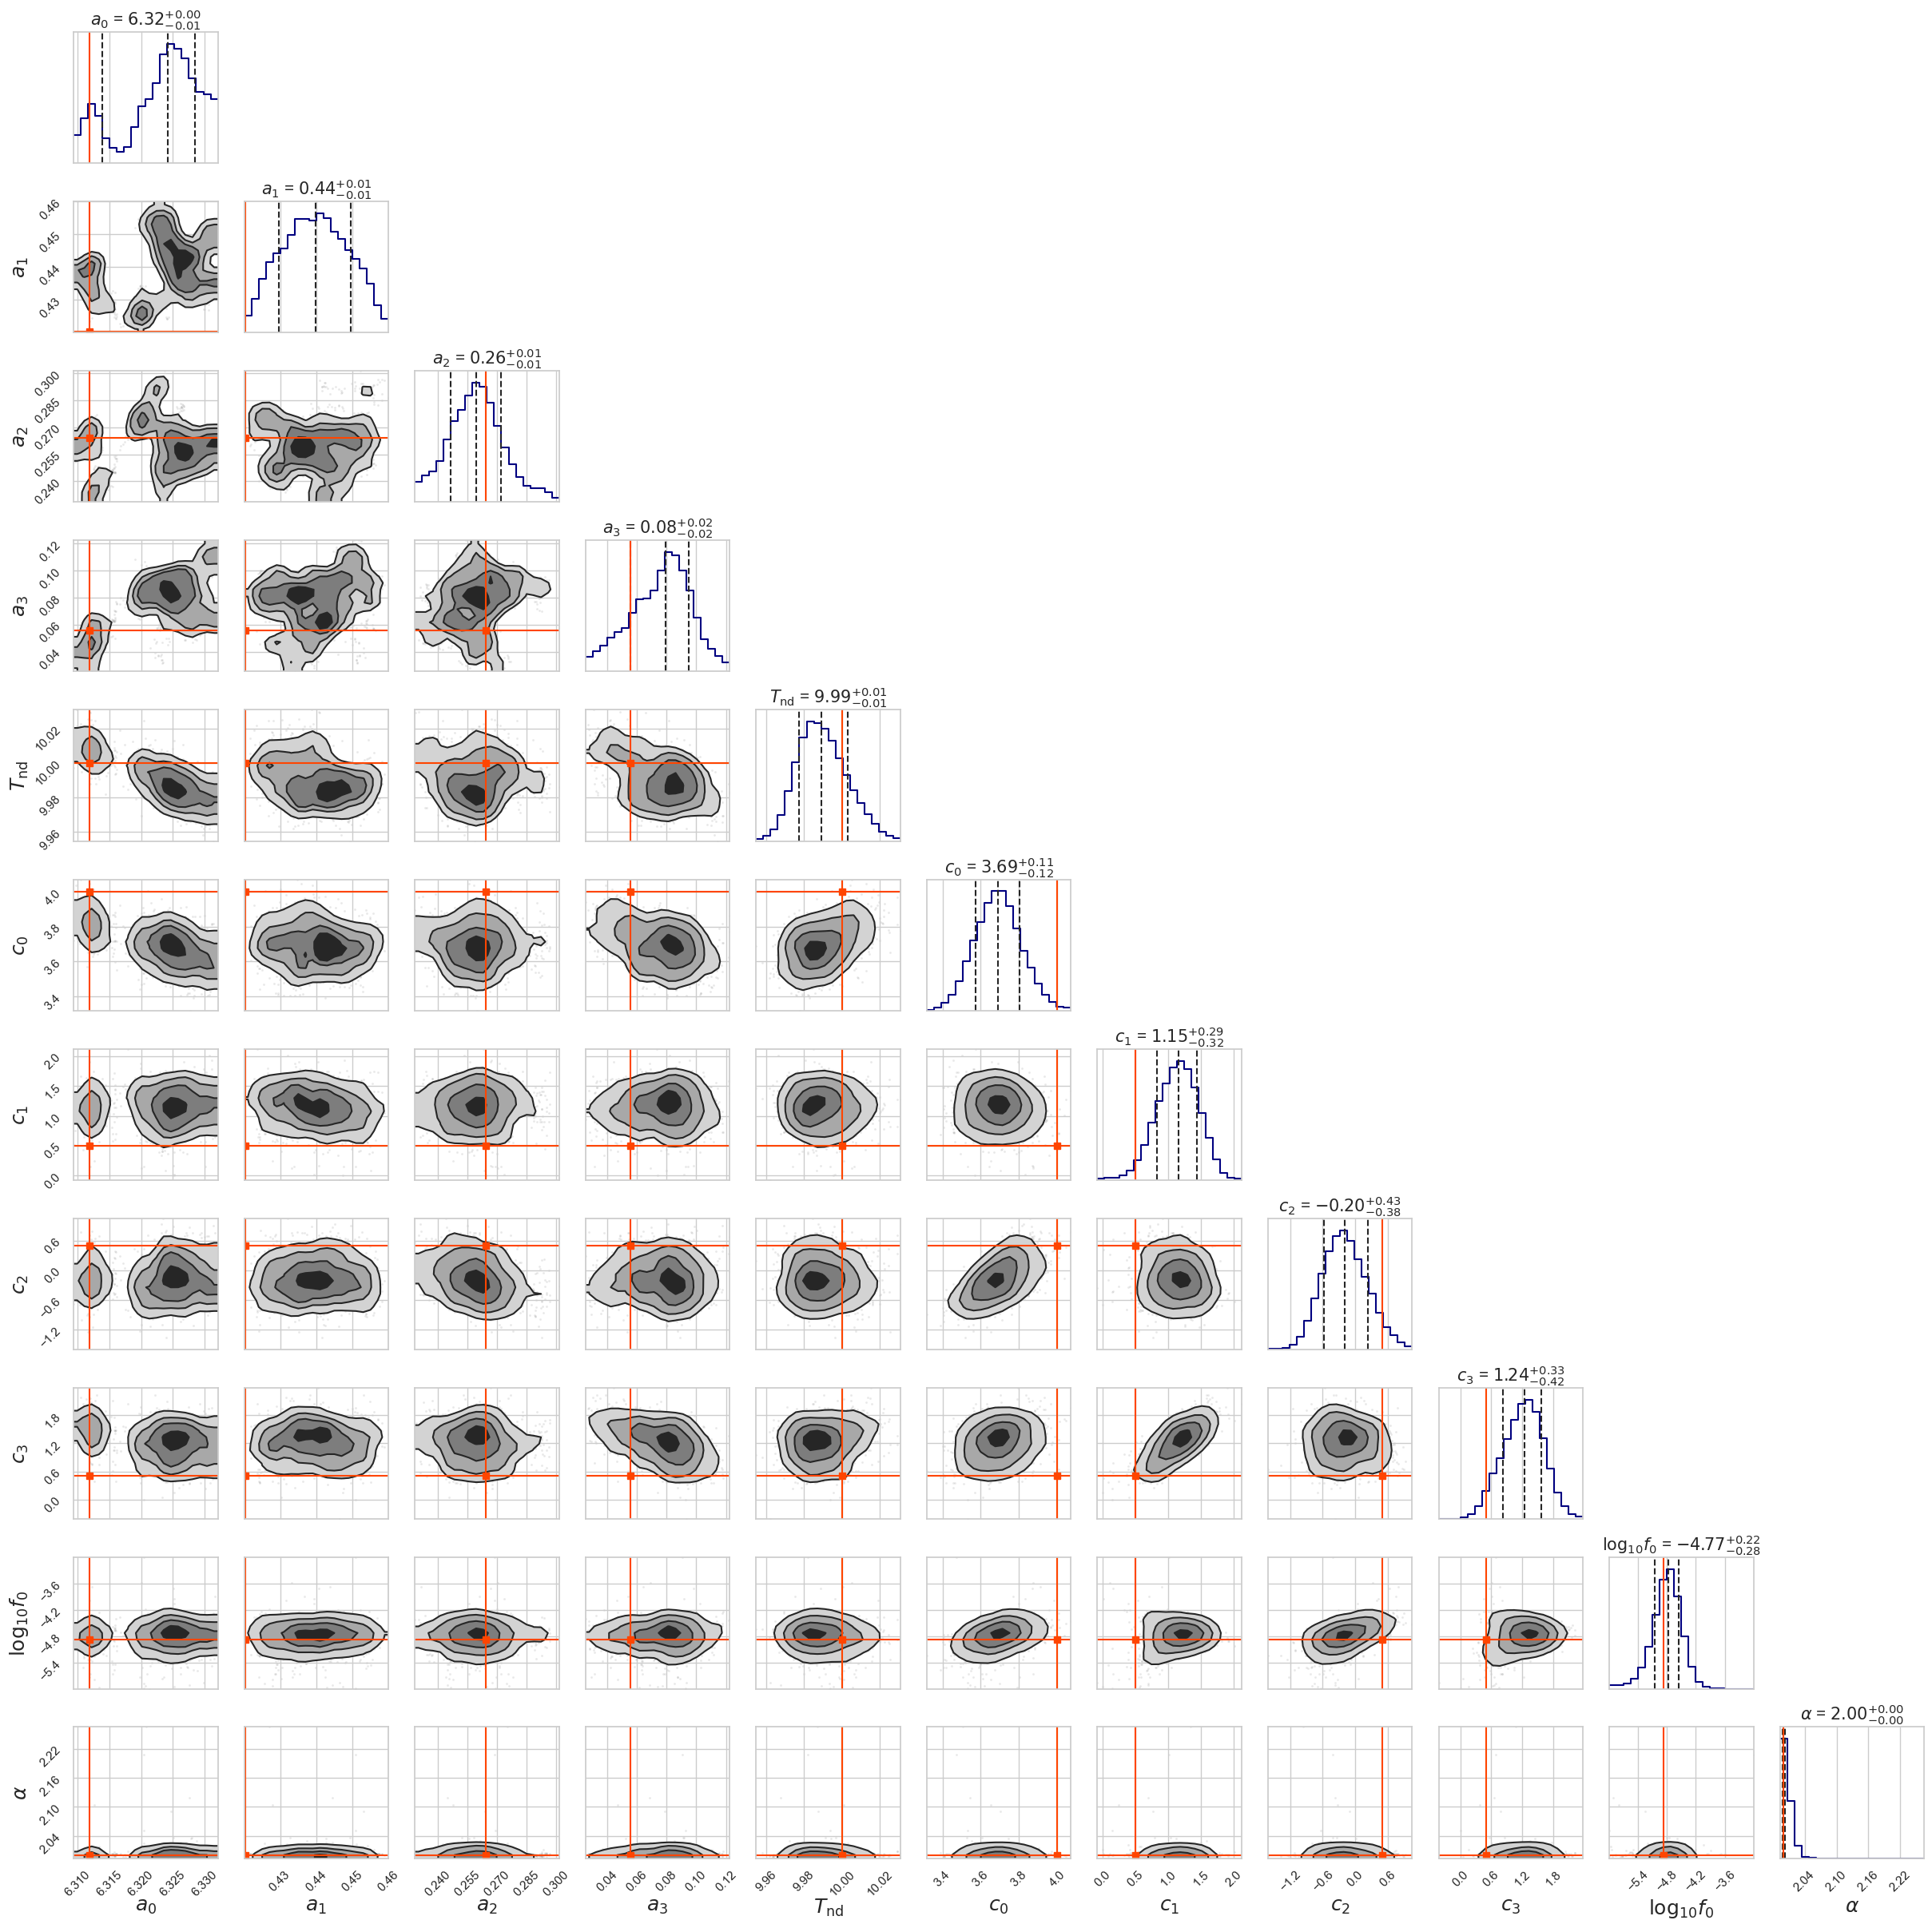

In [22]:
# Calculate residuals
residuals = Tmean - sky_params
from visualisation import *
plot_residual_histogram(residuals, save_path="./GSF5_residuals_histogram.pdf")
truths = list(gain_params_setting) + [T_ndiode]+ list(rec_params) + [logf0_list[0], alpha]
plot_corner(other_samples, truths=truths, label_kwargs={"fontsize": 18}, save_path='./GSF5_corner_plot.pdf')


In [23]:
def view_patch_map(map, pixel_indices):
    # Create a new map with just the patch (other pixels set to UNSEEN)
    patch_only_map = np.full(len(map), hp.UNSEEN)
    patch_only_map[pixel_indices] = map[pixel_indices]
    return patch_only_map


In [24]:
# Get pixel coordinates
theta, phi = hp.pix2ang(nside, pixel_indices)
lon, lat = np.degrees(phi), 90 - np.degrees(theta)
lon_center, lat_center = np.median(lon), np.median(lat)

# Calculate appropriate zoom/resolution
patch_size = 100  # Add 20% margin
res = patch_size / 20  # Adjust resolution based on patch size

In [25]:
sky_min = 20
sky_max = 70

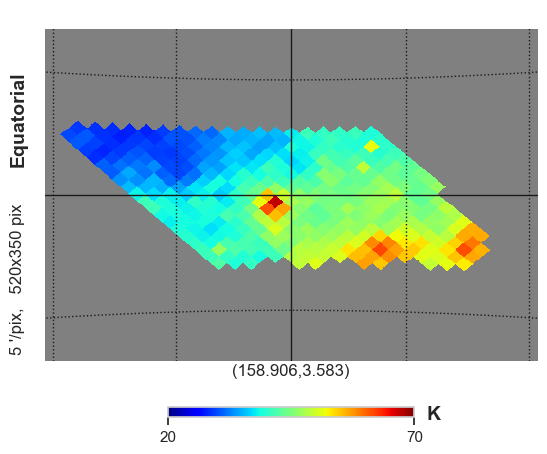

In [26]:
patch_true_map = view_patch_map(true_map, pixel_indices)

hp.gnomview(patch_true_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, 
           title=" ", 
           unit="K", cmap='jet', min=sky_min, max=sky_max,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig('outputs/GSF5/true_map.pdf', bbox_inches='tight', 
            pad_inches=0.1)

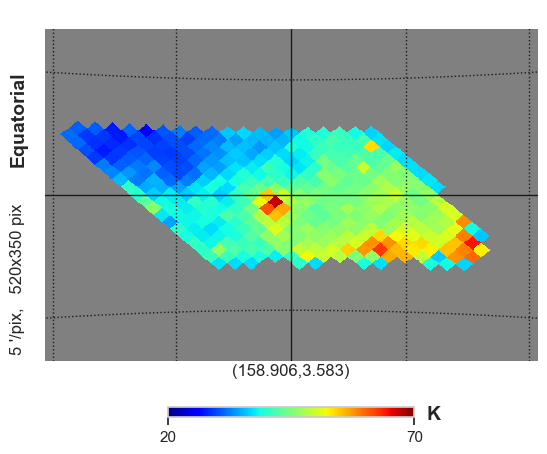

In [27]:
patch_mean_map = view_patch_map(sample_mean_map, pixel_indices)

hp.gnomview(patch_mean_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=" ", 
           unit="K", cmap='jet', min=sky_min, max=sky_max,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/GSF5/mean_map.pdf", bbox_inches='tight', 
            pad_inches=0.1)

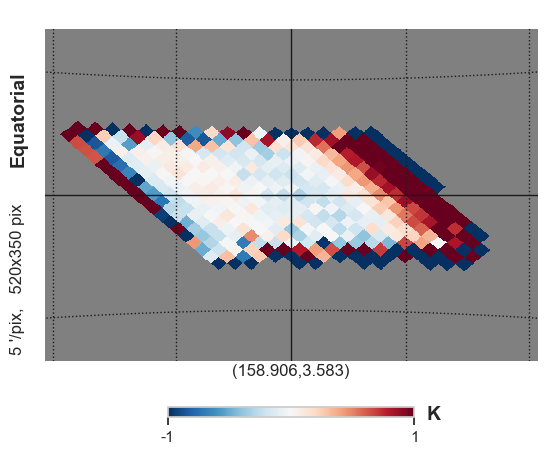

In [46]:
patch_error_map = view_patch_map(sample_mean_map-true_map, pixel_indices)
# plt.figure(figsize=(10, 6))
hp.gnomview(patch_error_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=" ", 
           unit="K", cmap='RdBu_r', min=-1, max=1,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False,
           badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/GSF5/error_map_multi_TOD.pdf", bbox_inches='tight', 
            pad_inches=0.1)

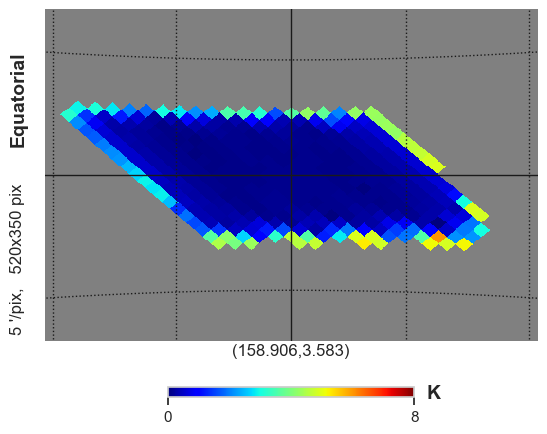

In [47]:
patch_std_map = view_patch_map(sample_std_map, pixel_indices)

hp.gnomview(patch_std_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=None, 
           unit="K", cmap='jet', 
           notext=False,
           coord=['C'], 
           cbar=True, 
           badcolor='gray',
           min=0, max=8,
           #norm='log'
           #sub=(2, 1, 1),  # Proper subplot specification
           #margins=(0.05, 0.15, 0.05, 0.15)
           )
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/GSF5/std_map_multi_TOD.pdf", bbox_inches='tight', 
            pad_inches=0.1)

In [ ]:

# # ---- Plot results ----
# # Generate a 2D plot of (RA, Dec) coordinates
# plt.figure(figsize=(12, 6))
# plt.scatter(equatorial_coords_setting.ra, equatorial_coords_setting.dec)
# plt.scatter(equatorial_coords_rising.ra, equatorial_coords_rising.dec)
# plt.xlabel("Right Ascension (degrees)")
# plt.ylabel("Declination (degrees)")
# plt.title("Sky Coordinates at Different Times")
# plt.show()


### Other components

In [ ]:
#gain_samples = np.load("outputs/GSF5/gain_samples.npy")

In [ ]:
all_noise_samples[0].shape

(1, 300, 2)


 Parameter 1:
True value: -4.874571
Mean sampled: -4.802523
Standard deviation: 0.294598
Relative error: -1.48%

 Parameter 2:
True value: 2.000000
Mean sampled: 2.001627
Standard deviation: 0.012794
Relative error: 0.08%


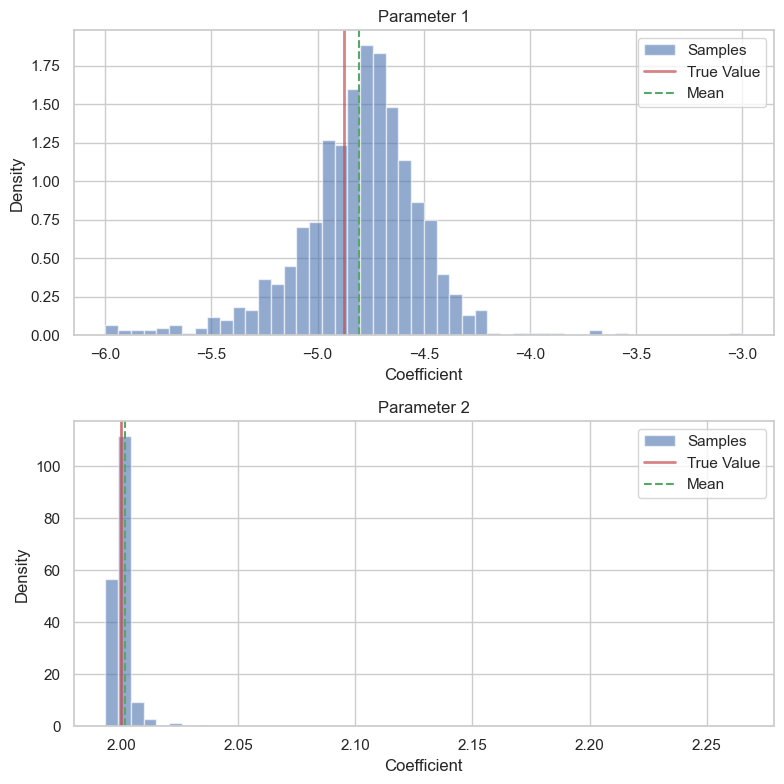

In [41]:
view_samples(all_noise_samples[0][0], [np.log10(f0), alpha])


 Parameter 1:
True value: 6.311943
Mean sampled: 6.322998
Standard deviation: 0.005928
Relative error: 0.18%

 Parameter 2:
True value: 0.420389
Mean sampled: 0.439750
Standard deviation: 0.008841
Relative error: 4.61%

 Parameter 3:
True value: 0.264222
Mean sampled: 0.259820
Standard deviation: 0.013601
Relative error: 1.67%

 Parameter 4:
True value: 0.055788
Mean sampled: 0.075861
Standard deviation: 0.019603
Relative error: 35.98%


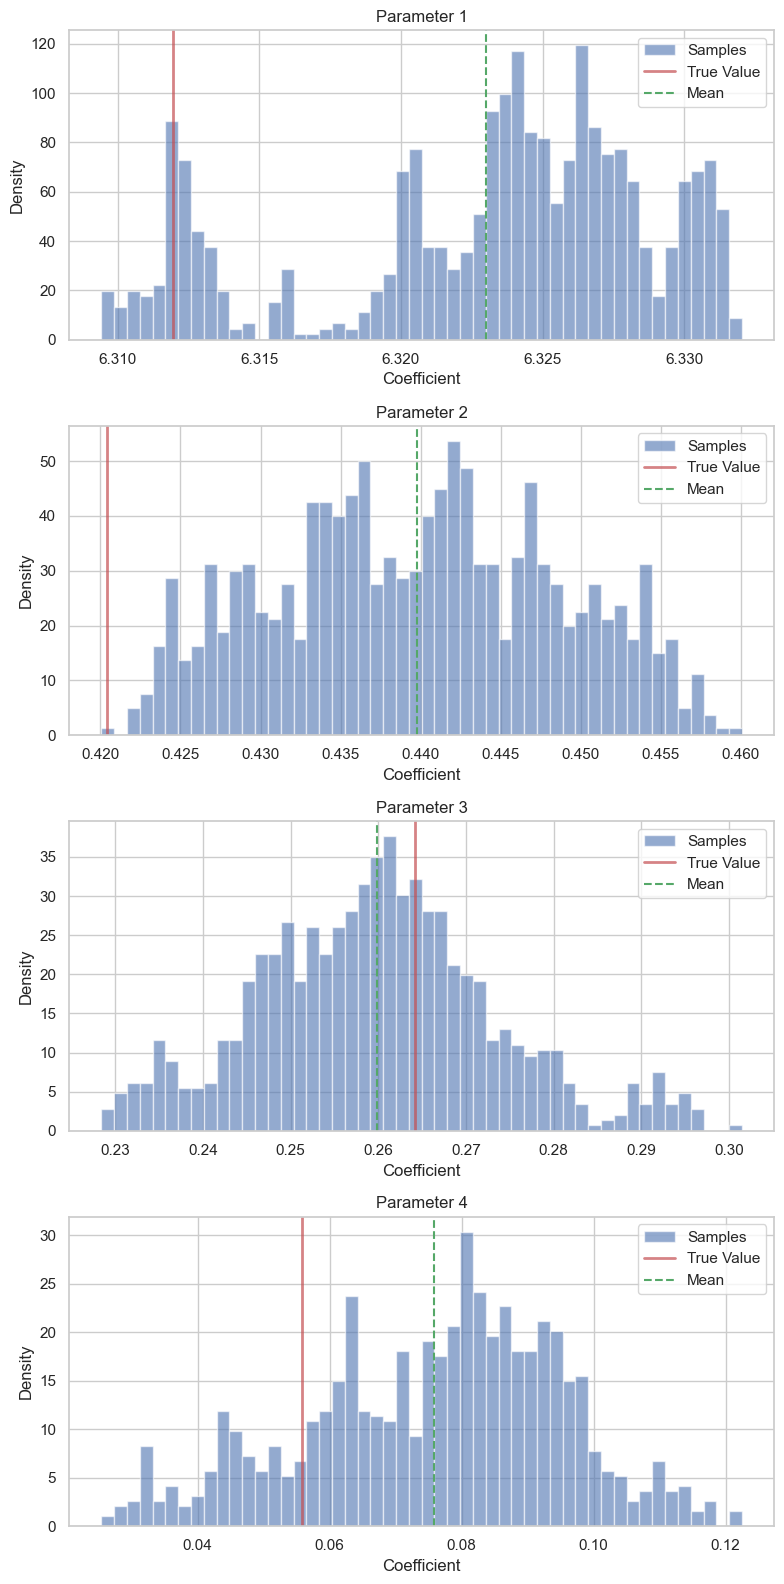

In [42]:
view_samples(all_gain_samples[0][0], gain_params_setting)


 Parameter 1:
True value: 10.000000
Mean sampled: 9.990010
Standard deviation: 0.012517
Relative error: 0.10%

 Parameter 2:
True value: 4.000000
Mean sampled: 3.692420
Standard deviation: 0.116426
Relative error: 7.69%

 Parameter 3:
True value: 0.500000
Mean sampled: 1.137203
Standard deviation: 0.311160
Relative error: 127.44%

 Parameter 4:
True value: 0.500000
Mean sampled: -0.184891
Standard deviation: 0.396181
Relative error: 136.98%

 Parameter 5:
True value: 0.500000
Mean sampled: 1.212588
Standard deviation: 0.378165
Relative error: 142.52%


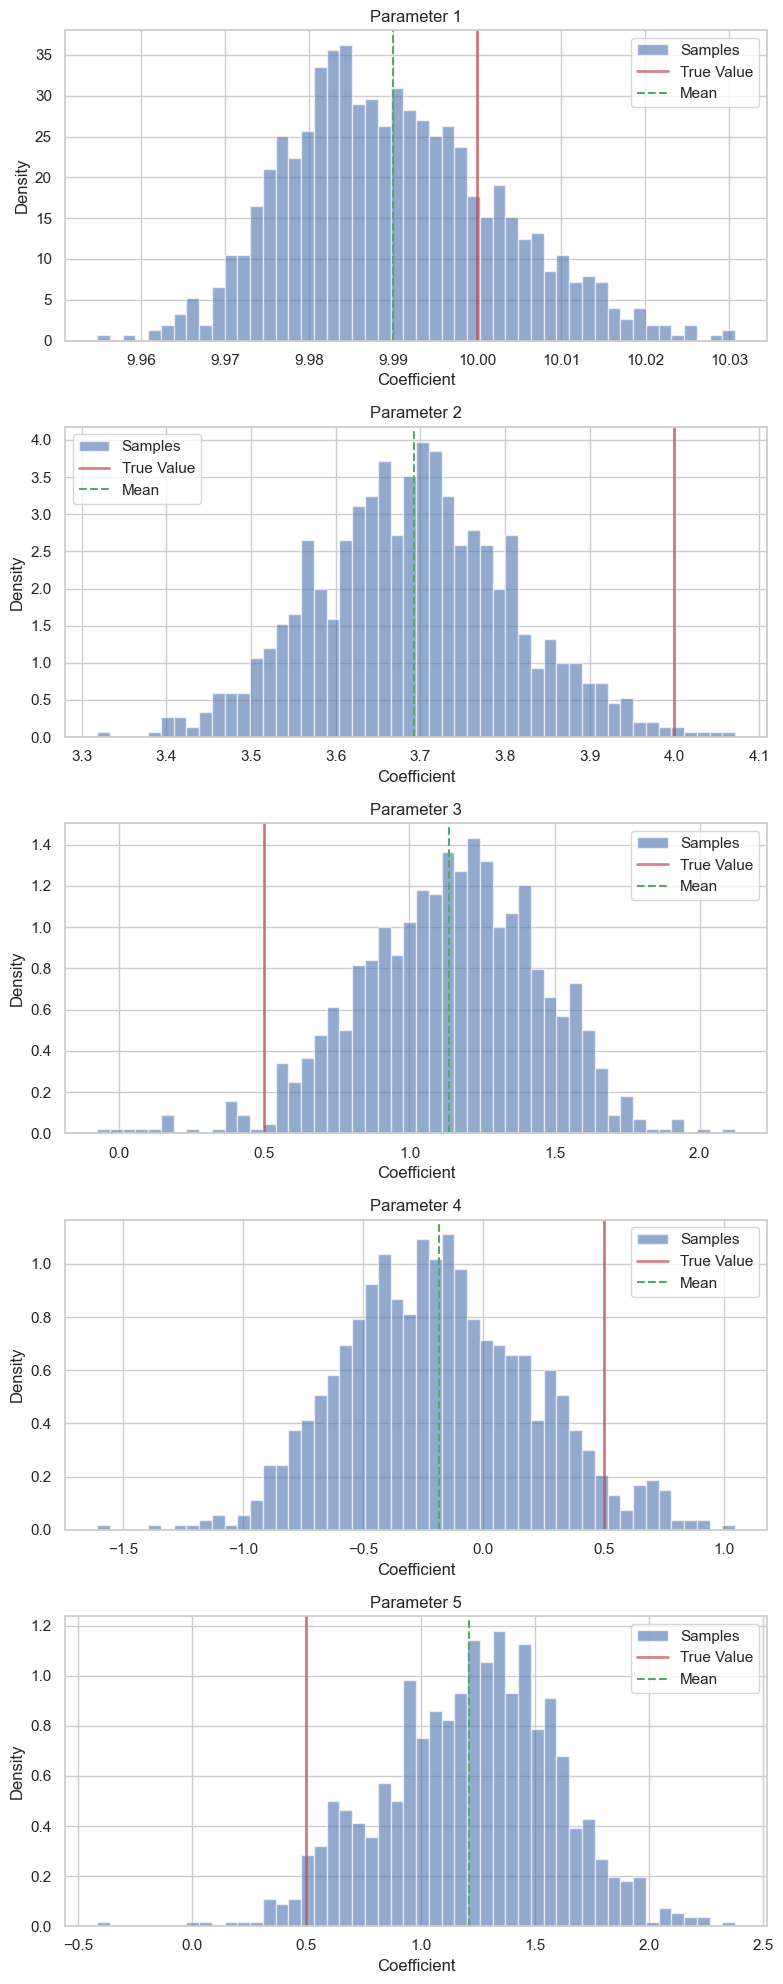

In [43]:
view_samples(Tsys_samples[:,-5:], nd_rec_params)